<a href="https://colab.research.google.com/github/parth-gulati/CMPT-732/blob/main/Copy_of_ResNet-implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import shutil
from google.colab import drive
import os
import fileinput
drive.mount('/content/drive', force_remount=True)
import torch.nn as nn

Mounted at /content/drive


In [23]:
if not os.path.exists('dataset_100'):
  !unzip /content/drive/MyDrive/dataset_100.zip -d dataset_100

In [24]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import os
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
import math
from torch.utils.data import Dataset, DataLoader

config

In [25]:
source = './dataset_100'
gpu = torch.cuda.is_available()

In [26]:
if not os.path.exists(source + '/landmarks'):
  os.mkdir(source+'/landmarks')
if not os.path.exists(source + '/segmentations'):
  os.mkdir(source+'/segmentations')
if not os.path.exists(source + '/images'):
  os.mkdir(source+'/images')  

In [27]:
for f in os.listdir(source):
  if f.endswith('.txt'):
    shutil.move(source + '/' + f, source + '/landmarks')

In [28]:
for f in os.listdir(source):
  if f.endswith('_seg.png'):
    shutil.move(source + '/' + f, source + '/segmentations')

In [29]:
for f in os.listdir(source):
     if f.endswith('.png'):
             shutil.move(source + '/' + f, source + '/images')

In [42]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 50
BATCH_SIZE = 4
DATA_PATH = './dataset_1000'

train_transforms = A.Compose(
    [
        A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
        A.Affine(shear=15, scale=1.0, mode=cv2.BORDER_REPLICATE, p=0.2),
        A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.OneOf([
            A.GaussNoise(p=0.8),
            A.CLAHE(p=0.8),
            A.ImageCompression(p=0.8),
            A.RandomGamma(p=0.8),
            A.Posterize(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(
            #mean=[0.4897, 0.4897, 0.4897],
            mean=[0.4897],
            #std=[0.2330, 0.2330, 0.2330],
            std=[0.2330],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

val_transforms = A.Compose(
    [
        A.Normalize(
            mean=[0.4897, 0.4897, 0.4897],
            std=[0.2330, 0.2330, 0.2330],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ], keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
)

dataset

In [43]:
class FacialDataset(Dataset):
    def __init__(self, data_dir, test_dir, train=True, train_test_split = 0.8):
        super().__init__()
        self.data_dir = data_dir
        self.test_dir = test_dir
        self.train = train
        self.data_length = len(os.listdir(self.data_dir))
        self.files = sorted(os.listdir(self.data_dir))[:math.ceil(self.data_length * train_test_split)] if self.train else sorted(os.listdir(self.data_dir))[math.ceil(self.data_length * train_test_split):]
        self.labels = sorted(os.listdir(self.test_dir))[:math.ceil(self.data_length * train_test_split)] if self.train else sorted(os.listdir(self.test_dir))[math.ceil(self.data_length * train_test_split):]

    def __getitem__(self, idx):
        img = cv2.imread(self.data_dir + '/' + self.files[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        cv2_imshow(img)
        label = self.test_dir + '/' + self.labels[idx]
        transformed_image = None
        transformed_keypoints = None

        points = []
        with open(label) as f:
            for line in f.readlines():
                line = line.rstrip().split(' ')
                x = float(line[0])
                y = float(line[1])
                points.append((x, y))

        if self.train:
            transformed = train_transforms(image=img, keypoints=points)
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']
        else:
            transformed = val_transforms(image=img, keypoints=points)
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']

        return {
            'image': transformed_image,
            'landmarks': transformed_keypoints
        }

    def __len__(self):
        return len(self.files)

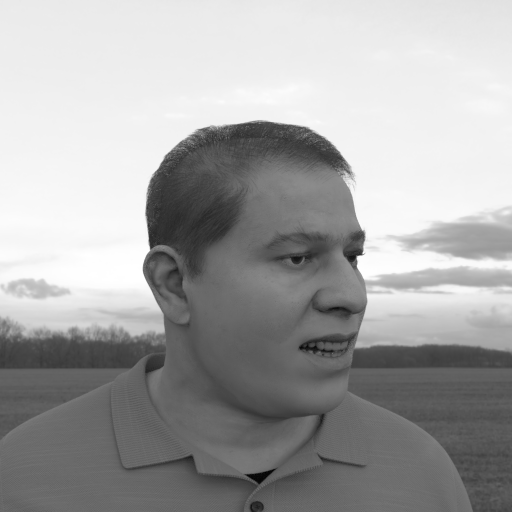

torch.Size([1, 512, 512])
(512, 512, 1)


TypeError: ignored

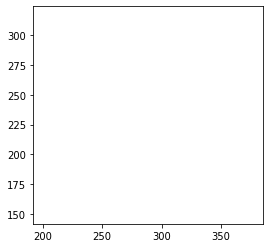

In [48]:
image_dir = 'dataset_100/images'
landmarks_dir = 'dataset_100/landmarks'

dataset = FacialDataset(image_dir, landmarks_dir)
item = dataset.__getitem__(0)
image = item['image']
print(image.shape)
image = image.numpy().transpose(1, 2, 0)
print(image.shape)
landmarks = item['landmarks']

for l in landmarks: 
  x = int(l[0])
  y = int(l[1])
  plt.plot(x, y, marker='o', color="white", markersize=1)

plt.imshow(image, cmap='gray')
plt.show()

In [49]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [50]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [51]:
class ResNet34(nn.Module):
    def __init__(self):
        super(ResNet34,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(1,1),
            ResidualBlock(64,64),
            ResidualBlock(64,64,2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(64,128),
            ResidualBlock(128,128,2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512),
            ResidualBlock(512,512,2)
        )
        
        self.avgpool = nn.AvgPool2d(2)
        # vowel_diacritic
        self.fc1 = nn.Linear(512,11)
        # grapheme_root
        self.fc2 = nn.Linear(512,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(512,7)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3


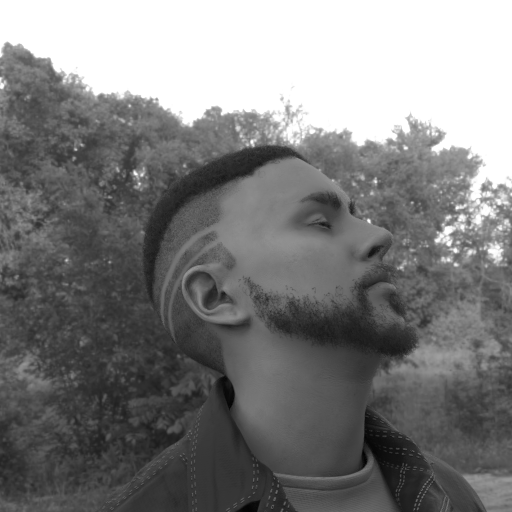

torch.Size([1, 1, 512, 512])


RuntimeError: ignored

In [56]:
trainset = FacialDataset(image_dir, landmarks_dir, train=True)
trainloader = DataLoader(trainset, batch_size = 1, shuffle=True)

testset = FacialDataset(image_dir, landmarks_dir, train = False)
testloader = DataLoader(testset, batch_size = 1)

epochs = 10
learning_rate = 1e-3
device = torch.device('cuda:0' if gpu else 'cpu')
model = ResNet34().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function = nn.MSELoss()

for e in range(epochs):
    model.train()
    for i, data in enumerate(trainloader):
        image, labels = data
        image = item['image']
        image = image.numpy().transpose(1, 2, 0)
        image = torch.from_numpy(image)
        image = image.permute(2, 0, 1)
        image = image.to(device)
        image = image.unsqueeze(0)

        labels = item['landmarks']

        print(image.shape)
        labels = torch.FloatTensor(labels)
        labels = labels.to(device)
        pred = model(image)
        loss = loss_function(pred, labels)
